In [1]:
with open('./function/requirements_import.py') as f:
    exec(f.read())
    
    # train_test_데이터 나누기
from sklearn.model_selection import train_test_split
# 최적모델찾기
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import RandomOverSampler

In [12]:
class_weights = {0: 0.12,
 1: 6.3,
 2: 4.0,
 3: 4.62,
 4: 4.29,
 5: 3.43,
 6: 5.15,
 7: 6.85,
 8: 17.74,
 9: 20.89}

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )

# 시계열 데이터 이미지화 데이터 로드

In [3]:
file_path = './data/rainfall_train_v5_all.csv'
rainfall = pd.read_csv(file_path)
rainfall = rainfall.drop(['vv', 'stn4contest', 'fc_year', 'ef_year'], axis=1)
rainfall['class_interval'] = rainfall['class_interval'].astype(int)
rainfall.shape

(1459120, 27)

In [4]:
target = 'class_interval'
x = rainfall.drop(target, axis=1)
y = rainfall.loc[:, target]

aa, bb = idx_find(x)

x_train = x.iloc[:aa+1]
y_train = y.iloc[:aa+1]

x_val = x.iloc[aa+1:bb+1]
y_val = y.iloc[aa+1:bb+1]

x_test = x.iloc[bb+1:]
y_test = y.iloc[bb+1:]

In [5]:
ss = StandardScaler()

x_train = ss.fit_transform(x_train)
x_val = ss.transform(x_val)
x_test = ss.transform(x_test)

# Model

## GASF

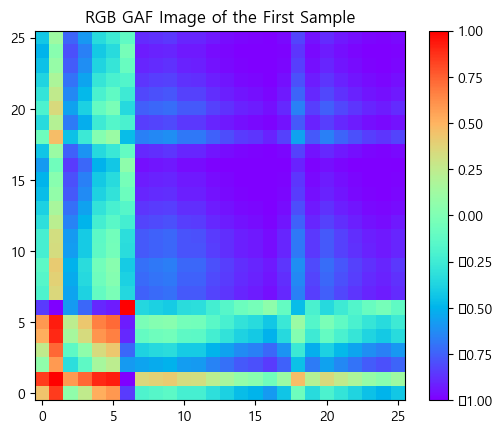

In [6]:
gaf = GramianAngularField(method='summation')
x_train_gaf = gaf.fit_transform(x_train)
x_val_gaf = gaf.transform(x_val)
x_test_gaf = gaf.transform(x_test)

plt.imshow(x_train_gaf[11], cmap='rainbow', origin='lower')
plt.title('RGB GAF Image of the First Sample')
plt.colorbar()
plt.show()

In [7]:
x_train_gaf.shape, x_val_gaf.shape, x_test_gaf.shape

((875360, 26, 26), (364720, 26, 26), (219040, 26, 26))

In [9]:
x_train_gaf4 = x_train_gaf.reshape(-1, 26, 26, 1)
x_val_gaf4= x_val_gaf.reshape(-1, 26, 26, 1)
x_test_gaf4= x_test_gaf.reshape(-1, 26, 26, 1)

In [19]:
ind_class = [np.where(y_train == i)[0] for i in range(10)]
min_samples = min(len(indices) for indices in ind_class)

# 각 범주에서 최소 데이터 수만큼 랜덤 샘플 추출
bal_ind = np.hstack([np.random.choice(indices, min_samples, replace=False) for indices in ind_class])

# 추출한 인덱스로 데이터와 레이블 준비
bal_x = x_train_gaf4[bal_ind]
bal_y = y_train[bal_ind]

(43720, 26, 26, 1)
------------------------------------------------------------------------------------------------------------------------------------------------------
class_interval
0    4372
1    4372
2    4372
3    4372
4    4372
5    4372
6    4372
7    4372
8    4372
9    4372
Name: count, dtype: int64


In [22]:
bal_x.shape

(43720, 26, 26, 1)

In [ ]:
ind_class = [np.where(y_val == i)[0] for i in range(10)]
min_samples = min(len(indices) for indices in ind_class)

# 각 범주에서 최소 데이터 수만큼 랜덤 샘플 추출
bal_ind = np.hstack([np.random.choice(indices, min_samples, replace=False) for indices in ind_class])

# 추출한 인덱스로 데이터와 레이블 준비
bal_x = x_val_gaf4[bal_ind]
bal_y = y_val[bal_ind]

In [26]:
# 0610_18:00기준 best
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Conv2D(128, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])


model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

# es.monitor='val_loss'
# es.patience=10

# 학습
history = model.fit(x_train_gaf4, y_train, epochs = 200, callbacks=[es], validation_data=(x_val_gaf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_gaf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

# beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 26, 26, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,370 (872.54 KB)

 Trainable params: 223,370 (872.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
10942/10942 ━━━━━━━━━━━━━━━━━━━━ 508s 46ms/step - accuracy: 0.2022 - csi_metric: 0.0170 - loss: 2.4166 - val_accuracy: 0.5356 - val_csi_metric: 0.0100 - val_loss: 1.9497
Epoch 2/200
10942/10942 ━━━━━━━━━━━━━━━━━━━━ 527s 48ms/step - accuracy: 0.5048 - csi_metric: 0.0112 - loss: 2.3181 - val_accuracy: 0.5244 - val_csi_metric: 0.0114 - val_loss: 1.8352
Epoch 3/200
10942/10942 ━━━━━━━━━━━━━━━━━━━━ 1896s 173ms/step - accuracy: 0.4780 - csi_metric: 0.0126 - loss: 2.2983 - val_accuracy: 0.5124 - val_csi_metric: 0.0124 - val_loss: 1.7951
Epoch 4/200
10942/10942 ━━━━━━━━━━━━━━━━━━━━ 448s 41ms/step - accuracy: 0.4719 - csi_metric: 0.0138 - loss: 2.2862 - val_accuracy: 0.5160 - val_csi_metric: 0.0124 - val_loss: 1.7746
Epoch 5/200
10942/10942 ━━━━━━━━━━━━━━━━━━━━ 471s 43ms/step - accuracy: 0.4767 - csi_metric: 0.0140 - loss: 2.2774 - val_accuracy: 0.5255 - val_csi_metric: 0.0121 - val_loss: 1.7502
Epoch 6/200
10942/10942 ━━━━━━━━━━━━━━━━━━━━ 1073s 98ms/step - accuracy: 0.4842 - csi_me

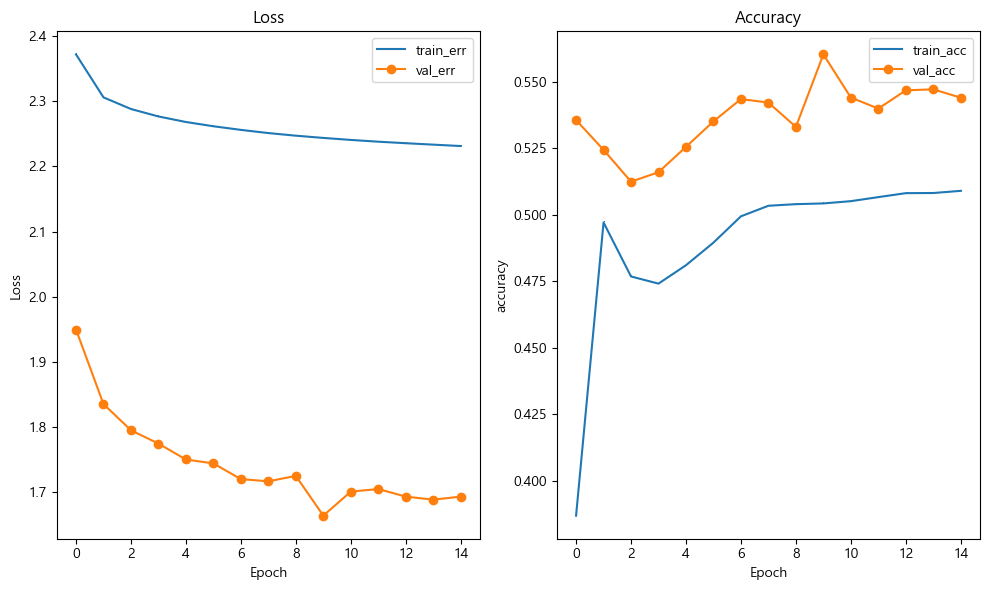

In [27]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

## GADF

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
# 종속변수
target = 'class_interval'

# x, y
x_pre = rainfall.drop(columns=[target])
x = pad_sequences(x_pre.values, maxlen=80)
y = rainfall.loc[:, target].astype(int)

aa, bb = idx_find(x_pre)

# 7:1.7:1.3 데이터로 분할
x_train = x[:aa+1]
y_train = y.iloc[:aa+1]

x_val = x[aa+1:bb+1]
y_val = y.iloc[aa+1:bb+1]

x_test = x[bb+1:]
y_test = y.iloc[bb+1:]
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(875360, 80) (364720, 80) (219040, 80)
(875360,) (364720,) (219040,)


In [ ]:
clear_session()

model = Sequential([
    LSTM(32, input_shape=(80, 1), activation='tanh'),
    Dropout(0.5),
    # LSTM(32, activation='tanh'),
    # Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])


# lr_sch = LearningRateScheduler(scheduler)

# 학습
history = model.fit(x_train, y_train, epochs = 300, callbacks=[es], validation_data=(x_val, y_val), batch_size=64).history #lr_sch, 

# 예측
pred = model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

# beepsound()

In [ ]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [31]:
from tensorflow.keras import layers, models, Model, Input

In [38]:
from tensorflow.keras import Model, Input
clear_session()

cnn_model = models.Sequential([Rescaling(1/255, input_shape=x_train.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(32, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten()])

# 입력 정의
input_layer = Input(shape=x_train.shape[1:])

# CNN 모델을 통해 특징 추출
cnn_features = cnn_model(input_layer)

# CNN 출력 reshape
output_shape = cnn_model.output_shape[-1]
cnn_features_reshaped = layers.Reshape((1, output_shape))(cnn_features)  # GRU 입력 형태에 맞추기 위해 reshape

# GRU 모델을 통해 분류
gru_model = models.Sequential([
    layers.GRU(32, return_sequences=True, input_shape=(None, output_shape)),
    layers.GRU(16),
    layers.Dense(10, activation='softmax')  # 이진 분류 예제
])

output_layer = gru_model(cnn_features_reshaped)

# 전체 모델 정의
model = Model(inputs=input_layer, outputs=output_layer)

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 80)

In [37]:
model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )
# 학습
history = model.fit(x_train_res, y_train_res, epochs = 300, callbacks=[es], validation_data=(x_val, y_val), batch_size=64).history #lr_sch, 

# 예측
pred = model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 26, 26, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 2304)           │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 2304)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │       227,018 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,834 (960.29 KB)

 Trainable params: 245,834 (960.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
680/684 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1046 - csi_metric: 0.1020 - loss: 2.3025

ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 26, 26, 1), found shape=(None, 80)

In [8]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [9]:
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_mtf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

lr_sch = LearningRateScheduler(scheduler)

# 학습
history = model.fit(x_train_mtf4, y_train, epochs = 10, callbacks=[lr_sch], validation_data=(x_val_mtf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_mtf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 21, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - accuracy: 0.3495 - csi_metric: 0.0165 - loss: 2.3777 - val_accuracy: 0.4704 - val_csi_metric: 0.0120 - val_loss: 1.7002 - learning_rate: 3.6788e-04
Epoch 2/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 125s 10ms/step - accuracy: 0.4635 - csi_metric: 0.0172 - loss: 2.2015 - val_accuracy: 0.4475 - val_csi_metric: 0.0184 - val_loss: 1.5523 - learning_rate: 3.3287e-04
Epoch 3/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - accuracy: 0.4433 - csi_metric: 0.0207 - loss: 2.1176 - val_accuracy: 0.4509 - val_csi_metric: 0.0191 - val_loss: 1.5207 - learning_rate: 3.2956e-04
Epoch 4/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 132s 10ms/step - accuracy: 0.4586 - csi_metric: 0.0209 - loss: 2.0849 - val_accuracy: 0.4595 - val_csi_metric: 0.0190 - val_loss: 1.4840 - learning_rate: 3.2923e-04
Epoch 5/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 133s 10ms/step - accuracy: 0.4711 - csi_metric: 0.0208 - loss: 2.0617 - val_accuracy: 0.4593 - val_csi_metric: 0.0193 - 

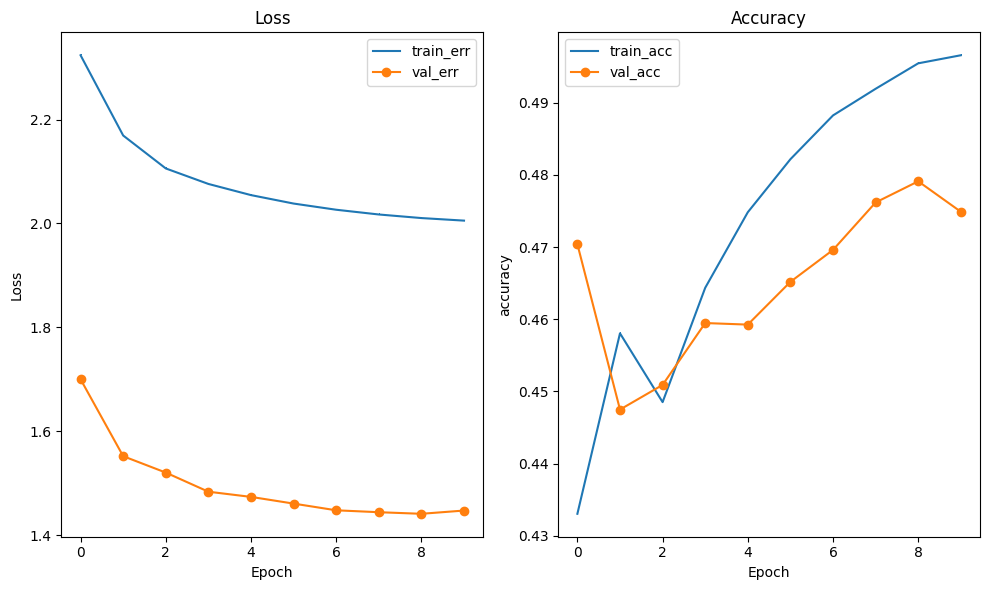

In [10]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [12]:
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_mtf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

lr_sch = LearningRateScheduler(scheduler)
es.patience = 20
es.monitor = 'val_accuracy'

# 학습
history = model.fit(x_train_mtf4, y_train, epochs = 300, callbacks=[lr_sch, es], validation_data=(x_val_mtf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_mtf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 21, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 124s 10ms/step - accuracy: 0.3186 - csi_metric: 0.0161 - loss: 2.3898 - val_accuracy: 0.4209 - val_csi_metric: 0.0115 - val_loss: 1.8148 - learning_rate: 3.6788e-04
Epoch 2/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 116s 9ms/step - accuracy: 0.4357 - csi_metric: 0.0130 - loss: 2.2990 - val_accuracy: 0.4553 - val_csi_metric: 0.0116 - val_loss: 1.7323 - learning_rate: 3.3287e-04
Epoch 3/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 114s 9ms/step - accuracy: 0.4556 - csi_metric: 0.0141 - loss: 2.2705 - val_accuracy: 0.4763 - val_csi_metric: 0.0128 - val_loss: 1.6838 - learning_rate: 3.2956e-04
Epoch 4/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 122s 10ms/step - accuracy: 0.4724 - csi_metric: 0.0156 - loss: 2.2431 - val_accuracy: 0.4690 - val_csi_metric: 0.0148 - val_loss: 1.6641 - learning_rate: 3.2923e-04
Epoch 5/300
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 122s 10ms/step - accuracy: 0.4695 - csi_metric: 0.0174 - loss: 2.2237 - val_accuracy: 0.4504 - val_csi_metric: 0.0166

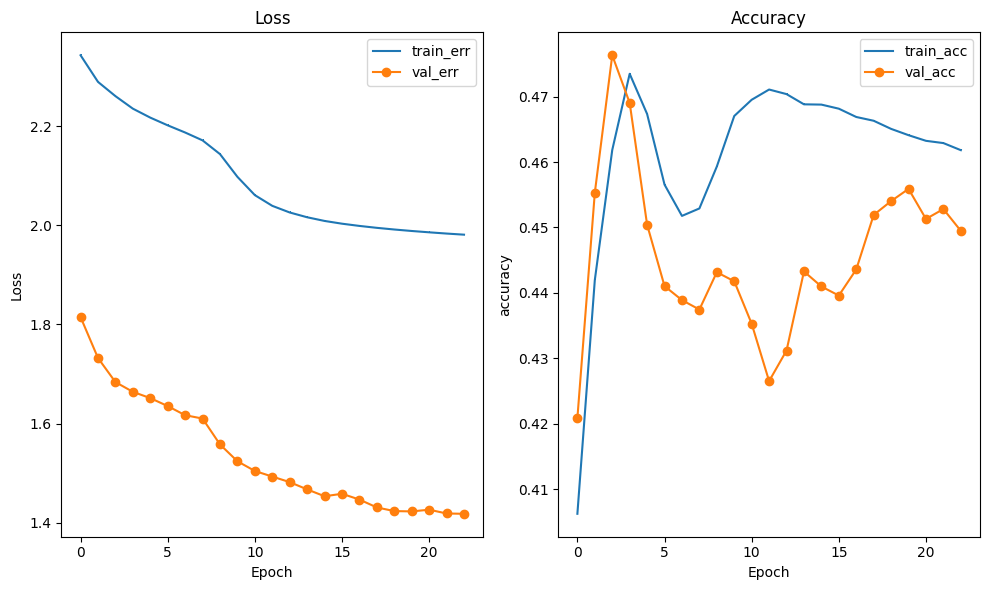

In [13]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

## GASF+GADF

In [5]:
gasf = GramianAngularField(method='summation')
x_train_gasf = gasf.fit_transform(x_train)
x_val_gasf = gasf.transform(x_val)
x_test_gasf = gasf.transform(x_test)

gadf = GramianAngularField(method='difference')
x_train_gadf = gadf.fit_transform(x_train)
x_val_gadf = gadf.transform(x_val)
x_test_gadf = gadf.transform(x_test)

In [9]:
x_train_gaf = np.concatenate((x_train_gasf,x_train_gadf,np.zeros(x_train_gadf.shape)),axis=-1)
x_val_gaf = np.concatenate((x_val_gasf,x_val_gadf,np.zeros(x_val_gadf.shape)),axis=-1)
x_test_gaf = np.concatenate((x_test_gasf,x_test_gadf,np.zeros(x_test_gadf.shape)),axis=-1)

plt.imshow(x_train_gaf[11], cmap='rainbow', origin='lower')
plt.title('RGB GAF Image of the First Sample')
plt.colorbar()
plt.show()

print('gaf : ', x_train_gaf.shape, x_val_gaf.shape, x_test_gaf.shape)
print('y : ', y_train.shape, y_val.shape, y_test.shape)

MemoryError: Unable to allocate 3.34 GiB for an array with shape (1016800, 21, 21) and data type float64

In [ ]:
x_train_gaf4 = x_train_gaf.reshape(-1, 21, 21, 1)
x_val_gaf4= x_val_gaf.reshape(-1, 21, 21, 1)
x_test_gaf4= x_test_gaf.reshape(-1, 21, 21, 1)

In [ ]:
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

lr_sch = LearningRateScheduler(scheduler)

# 학습
history = model.fit(x_train_gaf4, y_train, epochs = 10, callbacks=[lr_sch], validation_data=(x_val_gaf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_gaf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 21, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       204,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 190s 15ms/step - accuracy: 0.4344 - loss: 2.2793 - val_accuracy: 0.5218 - val_loss: 1.2840
Epoch 2/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 163s 13ms/step - accuracy: 0.5250 - loss: 1.9136 - val_accuracy: 0.4498 - val_loss: 1.2574
Epoch 3/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 161s 13ms/step - accuracy: 0.5201 - loss: 1.8545 - val_accuracy: 0.4951 - val_loss: 1.2224
Epoch 4/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 162s 13ms/step - accuracy: 0.5294 - loss: 1.8263 - val_accuracy: 0.5011 - val_loss: 1.2148
Epoch 5/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 166s 13ms/step - accuracy: 0.5257 - loss: 1.8088 - val_accuracy: 0.4946 - val_loss: 1.2105
Epoch 6/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 164s 13ms/step - accuracy: 0.5253 - loss: 1.7942 - val_accuracy: 0.4988 - val_loss: 1.1992
Epoch 7/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 167s 13ms/step - accuracy: 0.5222 - loss: 1.7791 - val_accuracy: 0.4907 - val_loss: 1.2083
Epoch 8/10
12710/12710 ━━━━━━━━━━━━━━━━━━━━ 151s 12ms/s

In [ ]:
# 주어진 데이터셋

model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(32, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')])


model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])
# es = EarlyStopping(monitor='val_csi_metric',        # 얼리스토핑을 적용할 관측 지표
#                 min_delta=0,               # 임계값
#                 patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
#                 verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
#                 restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
#                 )
# 학습
history = model.fit(x_train_gaf4, y_train, epochs = 10, validation_data=(x_val_gaf4, y_val), batch_size=80, class_weight=class_weights).history

# 예측
pred = model.predict(x_test_gaf4)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
recall = recall_score(y_test, pred_1, average='macro')
print(cm,recall)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 21, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,082 (402.66 KB)

 Trainable params: 103,082 (402.66 KB)

 Non-trainable params: 0 (0.00 B)

12710/12710 ━━━━━━━━━━━━━━━━━━━━ 127s 10ms/step - accuracy: 0.4618 - csi_metric: 0.0164 - loss: 2.2604 - val_accuracy: 0.5230 - val_csi_metric: 0.0227 - val_loss: 1.2817
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


NameError: name 'np' is not defined

In [ ]:
import time
result = {}
for temp in [10, 16, 20, 40]:
    model = Sequential([Rescaling(1/255, input_shape=x_train_gaf4.shape[1:]), # input_shape=(32, 32, 3)
                        Conv2D(32, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                        MaxPooling2D(pool_size = 2 ),
                        Flatten(),
                        Dense(32, activation='relu'),
                        Dense(10, activation='softmax')])

    # 모델 설정
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

    # 학습
    model.fit(x_train_gaf4, y_train, epochs = 5, validation_data=(x_val_gaf4, y_val), batch_size=temp, class_weight=class_weights)

    # 예측
    pred = model.predict(x_test_gaf4)
    pred_1 = pred.argmax(axis=1)

    cm = confusion_matrix(y_test, pred_1)
    recall = recall_score(y_test, pred_1, average='macro')
    result[temp] = [csi(cm), recall]
    
    time.sleep(5)

beepsound()
result

Epoch 1/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 474s 5ms/step - accuracy: 0.4407 - csi_metric: 0.0176 - loss: 2.2510 - val_accuracy: 0.4023 - val_csi_metric: 0.0268 - val_loss: 1.2892
Epoch 2/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 449s 4ms/step - accuracy: 0.4204 - csi_metric: 0.0255 - loss: 1.9423 - val_accuracy: 0.3789 - val_csi_metric: 0.0318 - val_loss: 1.3312
Epoch 3/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 475s 5ms/step - accuracy: 0.4085 - csi_metric: 0.0291 - loss: 1.8872 - val_accuracy: 0.3771 - val_csi_metric: 0.0315 - val_loss: 1.3130
Epoch 4/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 460s 5ms/step - accuracy: 0.4086 - csi_metric: 0.0295 - loss: 1.8710 - val_accuracy: 0.3708 - val_csi_metric: 0.0322 - val_loss: 1.3213
Epoch 5/5
101680/101680 ━━━━━━━━━━━━━━━━━━━━ 446s 4ms/step - accuracy: 0.4098 - csi_metric: 0.0297 - loss: 1.8604 - val_accuracy: 0.3704 - val_csi_metric: 0.0327 - val_loss: 1.3245
4090/4090 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Epoch 1/5
63550/63550 ━━━━━━━━━━━━━━━━━━━━ 355s 6ms/

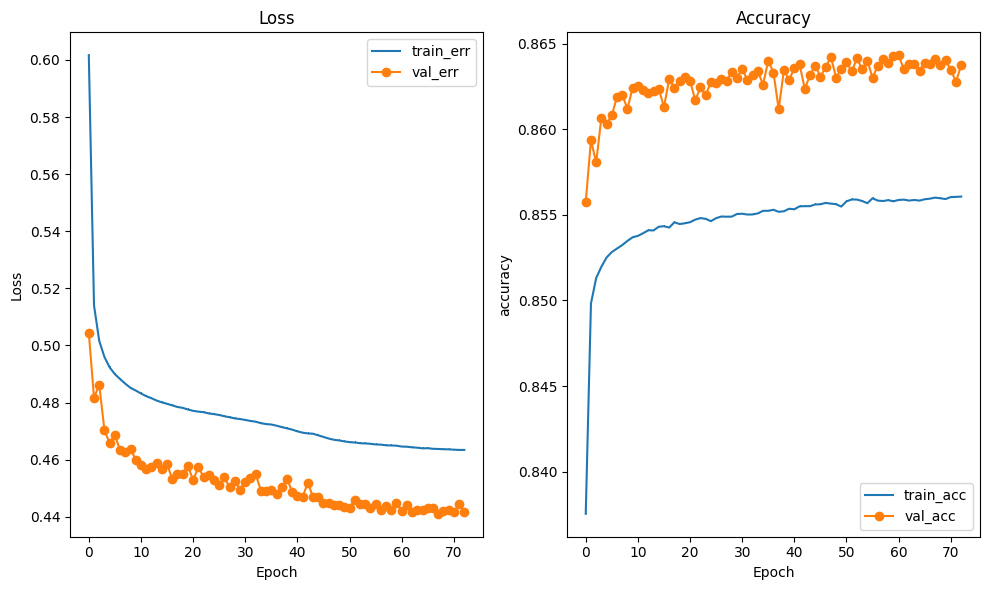

In [ ]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()